In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

### 0. Загрузка данных

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
df = data_train.copy()

### 1. Обзор данных и приведение типов

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df.shape

(7500, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

#### 1.1 Преобразуем колонку "Years in current job" в переменную, отпарсив значения. 

In [8]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### 1.2 Для значения '< 1 year' примем стаж равным нулю, а для остальных - их текущие значения.

In [9]:
df['Years in current job'] = df['Years in current job'].str.replace(r'(< 1 year)', '0')

In [10]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
0             563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [11]:
df['Years in current job'] = df['Years in current job'].str.extract(r'(10|[0-9])', expand=True)

In [12]:
df['Years in current job'].value_counts()

10    2332
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [13]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


#### 1.3 Наша целевая переменная

In [14]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### 2. Обработка выбросов

In [15]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### 2.1 В целом всё выглядит в рамках разумных пределов. Проверим некоторые наблюдения.

In [16]:
df.loc[df['Annual Income'] > 7000000, 'Annual Income']

1025     8923844.0
1601     7999095.0
1616     7907382.0
1984     8758449.0
2200     9338880.0
2474     8633790.0
2606     7883442.0
3081     7381842.0
3683     7514120.0
4491     8200229.0
5102     7637240.0
5108     7236606.0
5396     8710740.0
5774     7655480.0
6472    10149344.0
6604     7476880.0
7097     7660648.0
Name: Annual Income, dtype: float64

In [17]:
df.loc[df['Annual Income'] == 164597]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4240,Rent,164597.0,7,0.0,17.0,14.1,2086216.0,0.0,20.0,0.0,debt consolidation,Short Term,100892.0,129732.0,582.0,746.0,0


In [18]:
df.loc[df['Tax Liens'] > 5, 'Tax Liens']

1214    6.0
5373    6.0
5969    7.0
Name: Tax Liens, dtype: float64

In [19]:
df.loc[df['Years of Credit History'] > 50, 'Years of Credit History']

247     52.2
476     57.7
3091    50.9
3628    51.3
4301    51.9
4716    51.5
5673    50.6
7251    51.0
Name: Years of Credit History, dtype: float64

In [20]:
df.loc[df['Months since last delinquent'] > 90, 'Months since last delinquent']

4191    118.0
5202     91.0
5214     92.0
Name: Months since last delinquent, dtype: float64

#### 2.2 Особых аномалий замечено не было.

### 3. Обработка пропусков

In [21]:
len(df)-df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### 3.1 Построим функцию, которая будет помогать нам искать корреляцию между признаками.  

In [22]:
def correlations(TARGET_NAME):  
    BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
    NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)
    corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with ' + TARGET_NAME)
    plt.show()

#### 3.2 Начнем заполнение пробелов с "Annual Income"

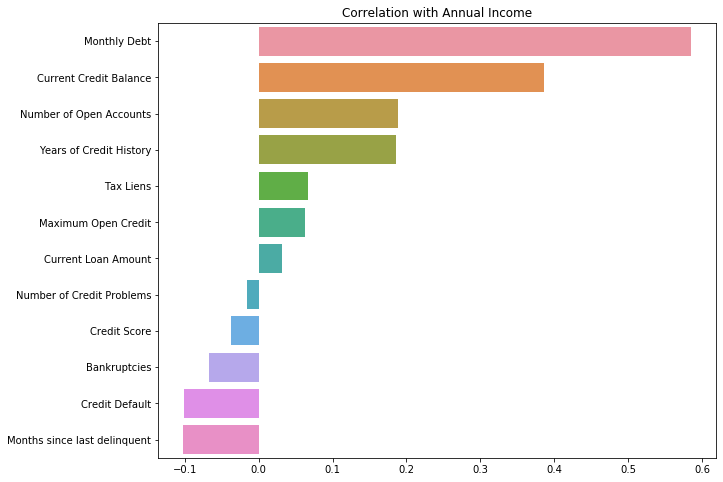

In [23]:
correlations('Annual Income')

#### 3.4 Проверим общие значения 'Annual Income'.

In [24]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

#### 3.5 Посмотрим зависимость 'Annual Income' от 'Monthly Debt' и 'Current Credit Balance'

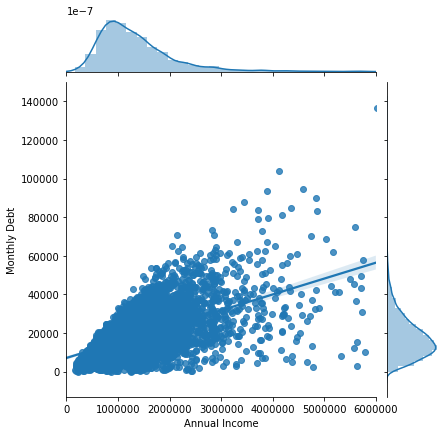

In [25]:
sns.jointplot(df.loc[df['Annual Income'].notnull(), 'Annual Income'], 
            df.loc[df['Annual Income'].notnull(), 'Monthly Debt'], kind='reg', xlim=(0, 6000000));

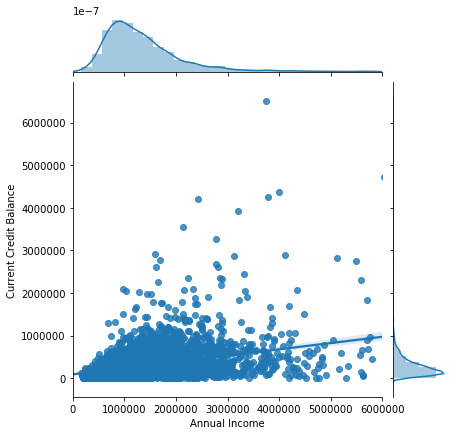

In [26]:
sns.jointplot(df.loc[df['Annual Income'].notnull(), 'Annual Income'], 
            df.loc[df['Annual Income'].notnull(), 'Current Credit Balance'], kind='reg', xlim=(0, 6000000));

#### 3.6 Используем усредненный коэффициент отношения 'Annual Income' к 'Monthly Debt' для того, чтобы восстановить значения в столбце 'Annual Income'. Ограничимся значениями 'Annual Income' до 3000000 для вычисления коэффициента. Будем иметь в виду, что нулевые знчения в знаменателе необходимо отбросить.


In [27]:
def coef(Source, Target, limit):
    # Null Temporary Dataframe
    df_ = pd.DataFrame(columns=['coefs'])
    df_ = df_.fillna(0) # with 0s rather than NaNs
    df_['coefs'] = df.loc[df[Source] < limit, Source]/\
                df.loc[df[Source] < limit, Target]
    df_ = df_.replace(np.Inf, np.NaN)
    
    target_coef = df_.dropna().mean()
    
    return target_coef

In [28]:
ai_md_coef = float(coef('Annual Income', 'Monthly Debt', 3000000))
ai_md_coef

110.15341006169132

#### 3.7 Восстановим значения 'Annual Income' используя все ненулевые значения 'Monthly Debt'.

In [29]:
df.loc[df['Annual Income'].isna(), ['Annual Income']] = df.loc[df['Annual Income'].isna(),\
                                                               ['Monthly Debt']].values * ai_md_coef
df.loc[df['Annual Income'].isna(), ['Annual Income']]

,Annual Income


#### 3.8 Для нулевых значений 'Annual Income' восстановим их из среднего значения, поскольку оба признака 'Monthly Debt' и 'Current Credit Balance' нулевые.

In [30]:
df.loc[df['Annual Income'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1643,Rent,0.0,9,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,0.0,10,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
7124,Rent,0.0,1,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


In [31]:
df['Annual Income'].mean()

1504665.9286374722

In [32]:
df.loc[df['Annual Income'] == 0, ['Annual Income']] = df['Annual Income'].mean()

In [33]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


#### 3.9 Продолжим с 'Months since last delinquent'

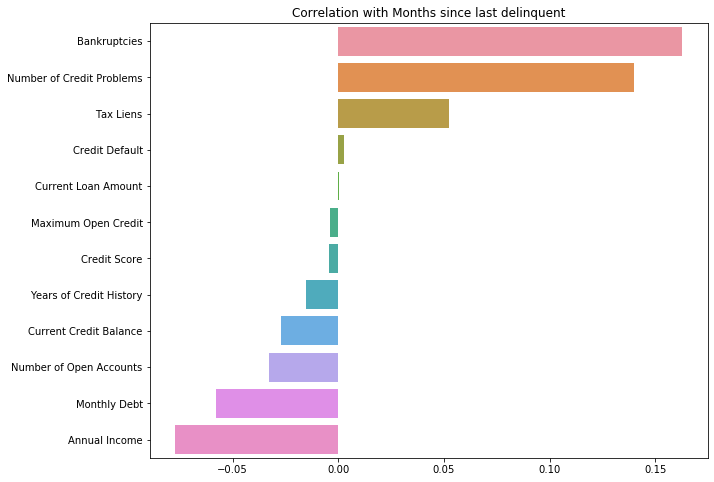

In [34]:
correlations('Months since last delinquent')

In [35]:
df['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [36]:
df['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

In [37]:
df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

#### 3.10 Поскольку значения 'Bankruptcies' и  'Number of Credit Problems' в основном нулевые, возьмем усредненное значение.

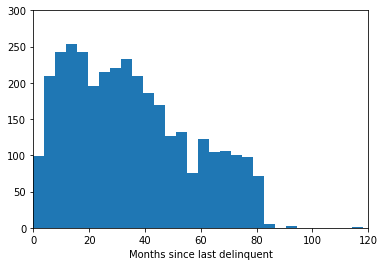

In [38]:
plt.axis([0, 120, 0, 300])
plt.xlabel('Months since last delinquent')
plt.hist(df.loc[df['Months since last delinquent'] < 120, 'Months since last delinquent'], bins=30);

In [39]:
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].mean(skipna = True)

In [40]:
df['Months since last delinquent'].describe()

count    7500.000000
mean       34.692600
std        14.642661
min         0.000000
25%        34.692600
50%        34.692600
75%        34.692600
max       118.000000
Name: Months since last delinquent, dtype: float64

In [41]:
len(df)-df.count()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### 3.11 Продолжим с 'Credit Score'

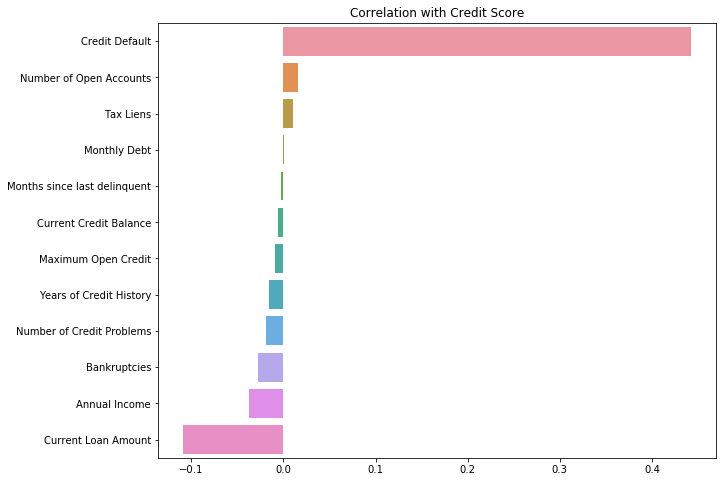

In [42]:
correlations('Credit Score')

#### 3.12 Мы не сможем восстановить значения из 'Credit Default' поскольку оно принимает только одно из двух значений. Возьмем также усредненное значение. 

In [43]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

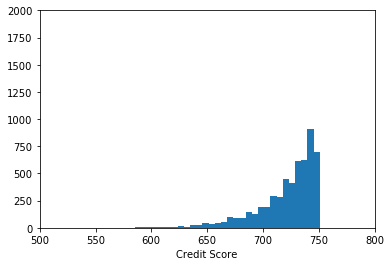

In [44]:
plt.axis([500, 800, 0, 2000])
plt.xlabel('Credit Score')
plt.hist(df.loc[df['Credit Score'] < 800, 'Credit Score'], bins=30);

In [45]:
df.loc[df['Credit Score'] > 760, 'Credit Score'].describe()

count     400.00000
mean     7115.10000
std       306.74537
min      6060.00000
25%      6987.50000
50%      7190.00000
75%      7340.00000
max      7510.00000
Name: Credit Score, dtype: float64

#### Судя по всему, мы столкнулись с аномалией, эти значения 'Credit Score' необходимо разделить на 10. 

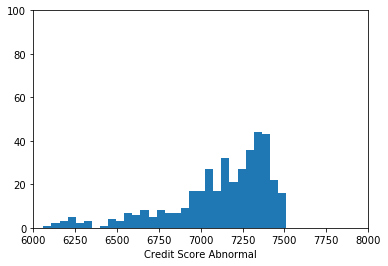

In [46]:
plt.axis([6000, 8000, 0, 100])
plt.xlabel('Credit Score Abnormal')
plt.hist(df.loc[df['Credit Score'] > 760, 'Credit Score'], bins=30);

In [47]:
df.loc[df['Credit Score'] > 760, 'Credit Score'] = df.loc[df['Credit Score'] > 760, 'Credit Score'].values / 10

In [48]:
df['Credit Score'].value_counts().head()

740.0    184
747.0    172
748.0    163
741.0    155
745.0    155
Name: Credit Score, dtype: int64

c:\users\dvasilyev\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\dvasilyev\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


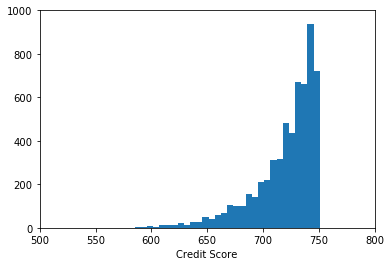

In [49]:
plt.axis([500, 800, 0, 1000])
plt.xlabel('Credit Score')
plt.hist(df['Credit Score'], bins=30);

#### Нулевые значения заменим матожиданием.

In [50]:
df.loc[df['Credit Score'].isna(), 'Credit Score'] = 740

In [51]:
len(df)-df.count()

Home Ownership                    0
Annual Income                     0
Years in current job            371
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                     14
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

#### 3.13 Рассмотрим 'Years in current job'.

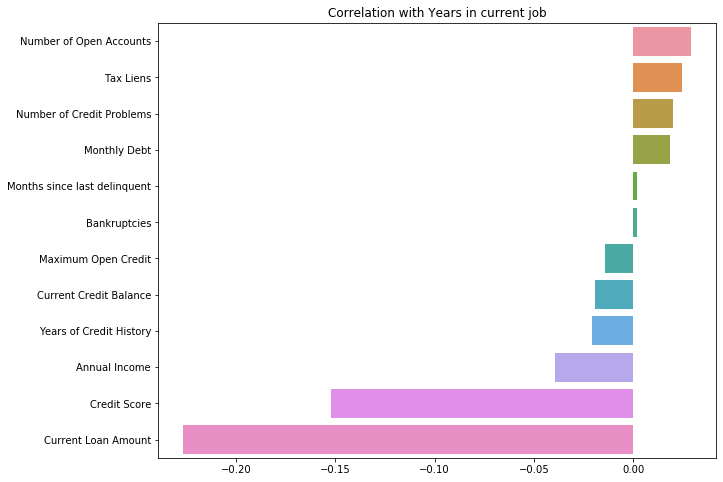

In [52]:
correlations('Years in current job')

#### 3.14 Возьмем нашу функцию но в этотм раз учитывая обратную корреляцию.

In [53]:
def coef_rev(Source, Target, limit):
    # Null Temporary Dataframe
    df_ = pd.DataFrame(columns=['coefs'])
    df_ = df_.fillna(0) # with 0s rather than NaNs
    df_['coefs'] = df.loc[df[Source] < limit, Source]*\
                   df.loc[df[Source] < limit, Target]
    df_ = df_.replace(np.Inf, np.NaN)
    
    target_coef = df_.dropna().mean()
    
    return target_coef

In [54]:
df['Years in current job'].describe()

count     7129
unique      11
top         10
freq      2332
Name: Years in current job, dtype: object

In [55]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

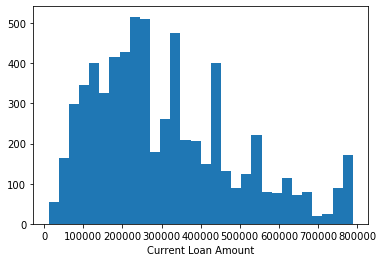

In [56]:
plt.xlabel('Current Loan Amount')
plt.hist(df.loc[df['Current Loan Amount'] < 2000000, 'Current Loan Amount'], bins=30);

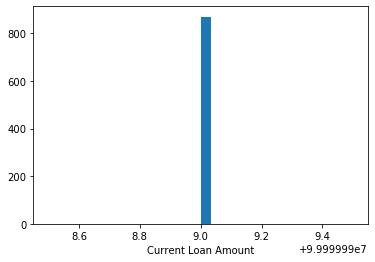

In [57]:
plt.xlabel('Current Loan Amount')
plt.hist(df.loc[df['Current Loan Amount'] > 2000000, 'Current Loan Amount'], bins=30);

#### Похоже и здесь мы столкнулись с аномалией, для всех аномальных значеинием 'Current Loan Amount'. Попробуем посмотреть корреляцию с другими признаками.

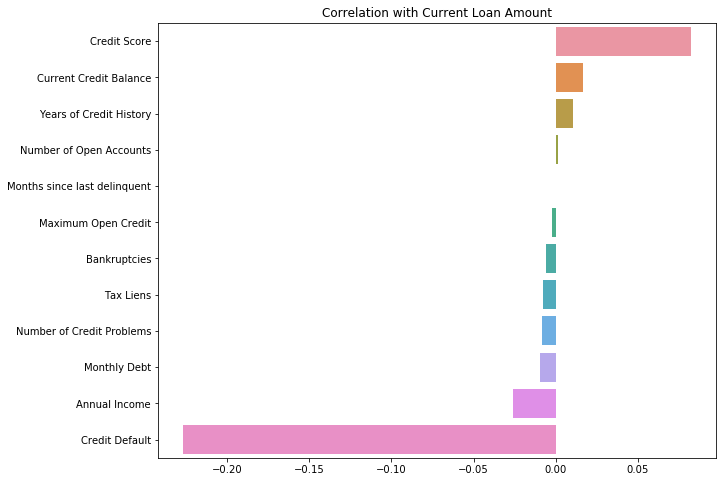

In [58]:
correlations('Current Loan Amount')

#### Попробуем восстановить значения используя 'Credit Score'.

In [59]:
cla_cs_coef = float(coef_rev('Current Loan Amount', 'Credit Score', 2000000))
cla_cs_coef

222650040.97918552

In [60]:
df.loc[df['Current Loan Amount'] > 2000000, 'Current Loan Amount'] = cla_cs_coef / df.loc[df['Current Loan Amount'] > 2000000, 'Credit Score']

In [61]:
df['Current Loan Amount'].describe()

count      7500.000000
mean     308579.312895
std      171429.447289
min       11242.000000
25%      180169.000000
50%      298058.957134
75%      396929.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

#### Вернемся к заполнению пробелов в  'Years in current job'.

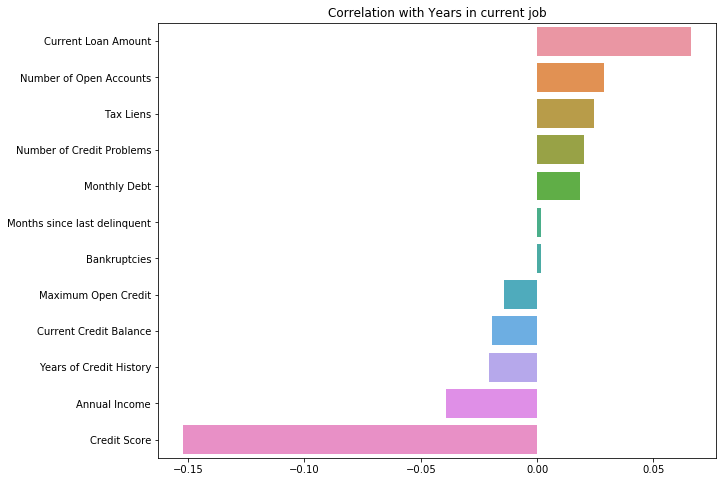

In [62]:
correlations('Years in current job')

In [63]:
df['Years in current job'] = df['Years in current job'].astype(float)

In [64]:
ycj_cs_coef = float(coef_rev('Years in current job', 'Credit Score', 12))

ycj_cs_coef

4257.347033244494

In [65]:
df.loc[df['Years in current job'].isna(), 'Years in current job'] = ycj_cs_coef / df.loc[df['Years in current job'].isna(), 'Credit Score']

In [66]:
df['Years in current job'].describe()

count    7500.000000
mean        5.881332
std         3.529865
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: Years in current job, dtype: float64

In [67]:
len(df)-df.count()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
dtype: int64

#### 3.15 Ну и наконец, заполним нулевые поля признака 'Bankruptcies'.

In [68]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

#### Очевидно что 0 будем естественным матожиданием. 

In [69]:
df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [70]:
len(df)-df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### 4. Построение новых признаков.

In [71]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,5.684041,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,297263.072068,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.000000,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,300067.440673,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,0
4,Rent,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,0


In [72]:
df['ID']=df.index.tolist()

In [73]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,5.684041,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,297263.072068,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.000000,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,300067.440673,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,0,4


#### Начнем с рассмотрения уникальных значений категориальных переменных

In [74]:
df['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [75]:
df['Ownership Type'] = df['Home Ownership'].map({'Own Home':'3','Home Mortgage':'2', 'Rent':'1', 'Have Mortgage':'0'}).astype(int)

In [76]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Ownership Type
0,Own Home,482087.0,5.684041,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,297263.072068,47386.0,7914.0,749.0,0,0,3
1,Own Home,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.000000,394972.0,18373.0,737.0,1,1,3
2,Home Mortgage,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,300067.440673,308389.0,13651.0,742.0,0,2,2
3,Own Home,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,0,3,3
4,Rent,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,0,4,1


In [77]:
df['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [78]:
df['Term Type'] = df['Term'].map({'Short Term':'1', 'Long Term':'2'}).astype(int)

In [79]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Ownership Type,Term Type
0,Own Home,482087.0,5.684041,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,297263.072068,47386.0,7914.0,749.0,0,0,3,1
1,Own Home,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.000000,394972.0,18373.0,737.0,1,1,3,2
2,Home Mortgage,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,300067.440673,308389.0,13651.0,742.0,0,2,2,1
3,Own Home,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,0,3,3,1
4,Rent,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,0,4,1,1


In [80]:
df['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

#### Ввиду многочисленности значений 'Purpose', оставим пока этот признак как есть.

### 5. Анализ целевой переменной

In [81]:
TARGET_NAME = 'Credit Default'

In [82]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

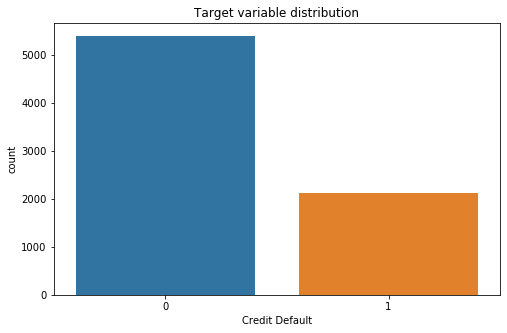

In [83]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

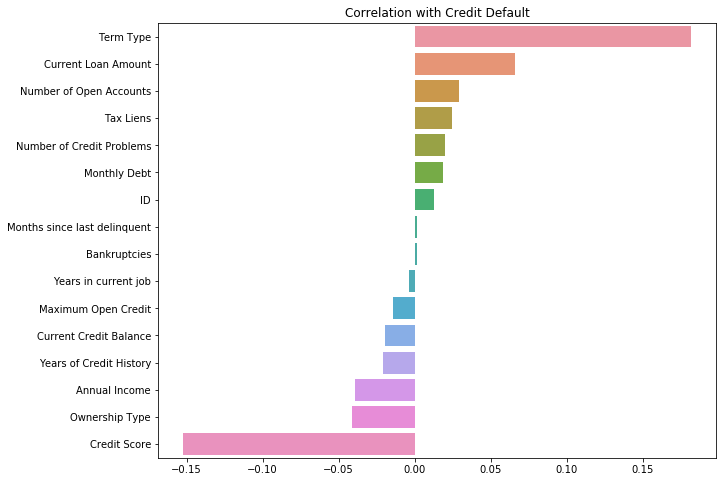

In [84]:
correlations(TARGET_NAME)

#### 5.1 Оценка признака 'Term Type' в разрезе целевой переменной

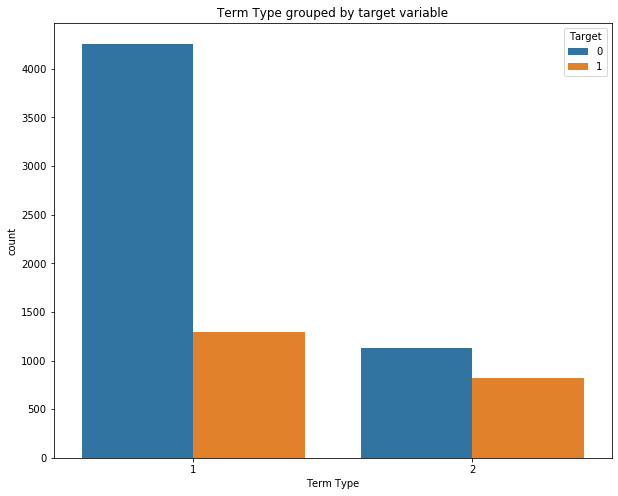

In [85]:
plt.figure(figsize=(10, 8))

sns.countplot(x='Term Type', hue=TARGET_NAME, data=df)
plt.title('Term Type grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### 5.2 Оценка признака 'Credit Score' в разрезе целевой переменной

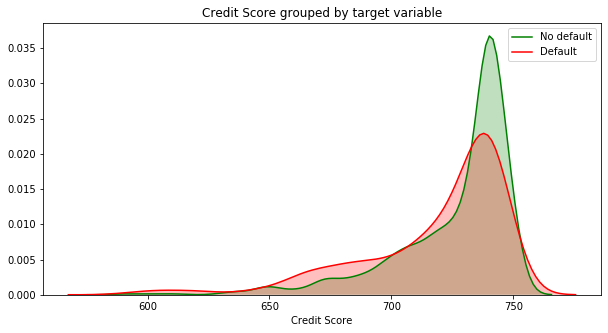

In [86]:
cs_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
cs_s = cs_with_target_s['Credit Score']
cs_target_0 = cs_s[cs_with_target_s[TARGET_NAME] == 0]
cs_target_1 = cs_s[cs_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cs_target_0, shade=True, label='No default', color='g')
sns.kdeplot(cs_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

#### Наблюдение

Похоже что две группы, полученные в результате разбиения признака "Credit Score" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit Score" и целевой переменной, возможно, существует некоторая функциональная зависимость.

#### Гипотеза

- Нулевая гипотеза: средние значения в двух независимых выборках равны
- Альтернативная гипотеза: средние значения в двух независимых выборках различаются
- Критерий: критерий Стьюдента (t-тест) и его аналоги
- Уровень значимости  α : 0.05
- Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [87]:
shapiro(cs_s)

(0.7889235019683838, 4.514885079563802e-34)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

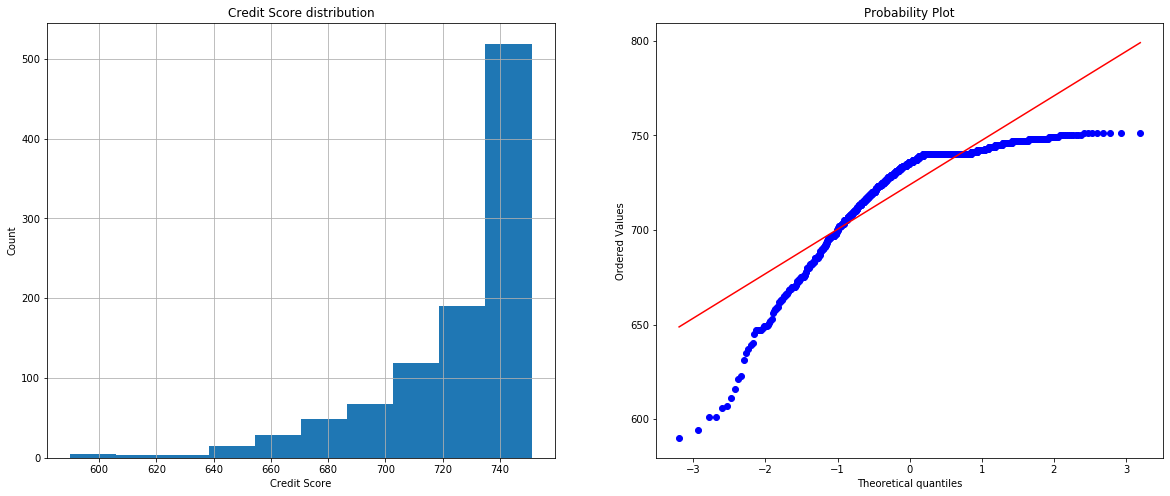

In [88]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
cs_s.hist()

plt.subplot(122)
probplot(cs_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Credit Score в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [89]:
mannwhitneyu(cs_target_0, cs_target_1)

MannwhitneyuResult(statistic=83797.0, pvalue=8.459702045170167e-07)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

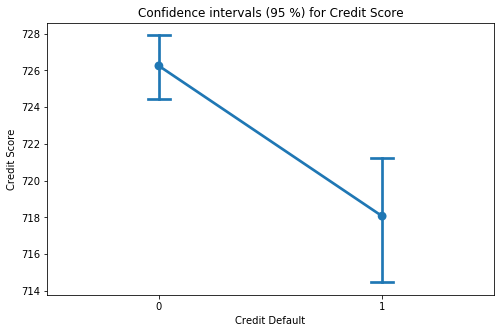

In [90]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=cs_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

#### 5.4 Анализ признакового пространства

In [91]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Ownership Type,Term Type
0,Own Home,482087.0,5.684041,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,297263.072068,47386.0,7914.0,749.0,0,0,3,1
1,Own Home,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.000000,394972.0,18373.0,737.0,1,1,3,2
2,Home Mortgage,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,300067.440673,308389.0,13651.0,742.0,0,2,2,1
3,Own Home,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,0,3,3,1
4,Rent,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,0,4,1,1


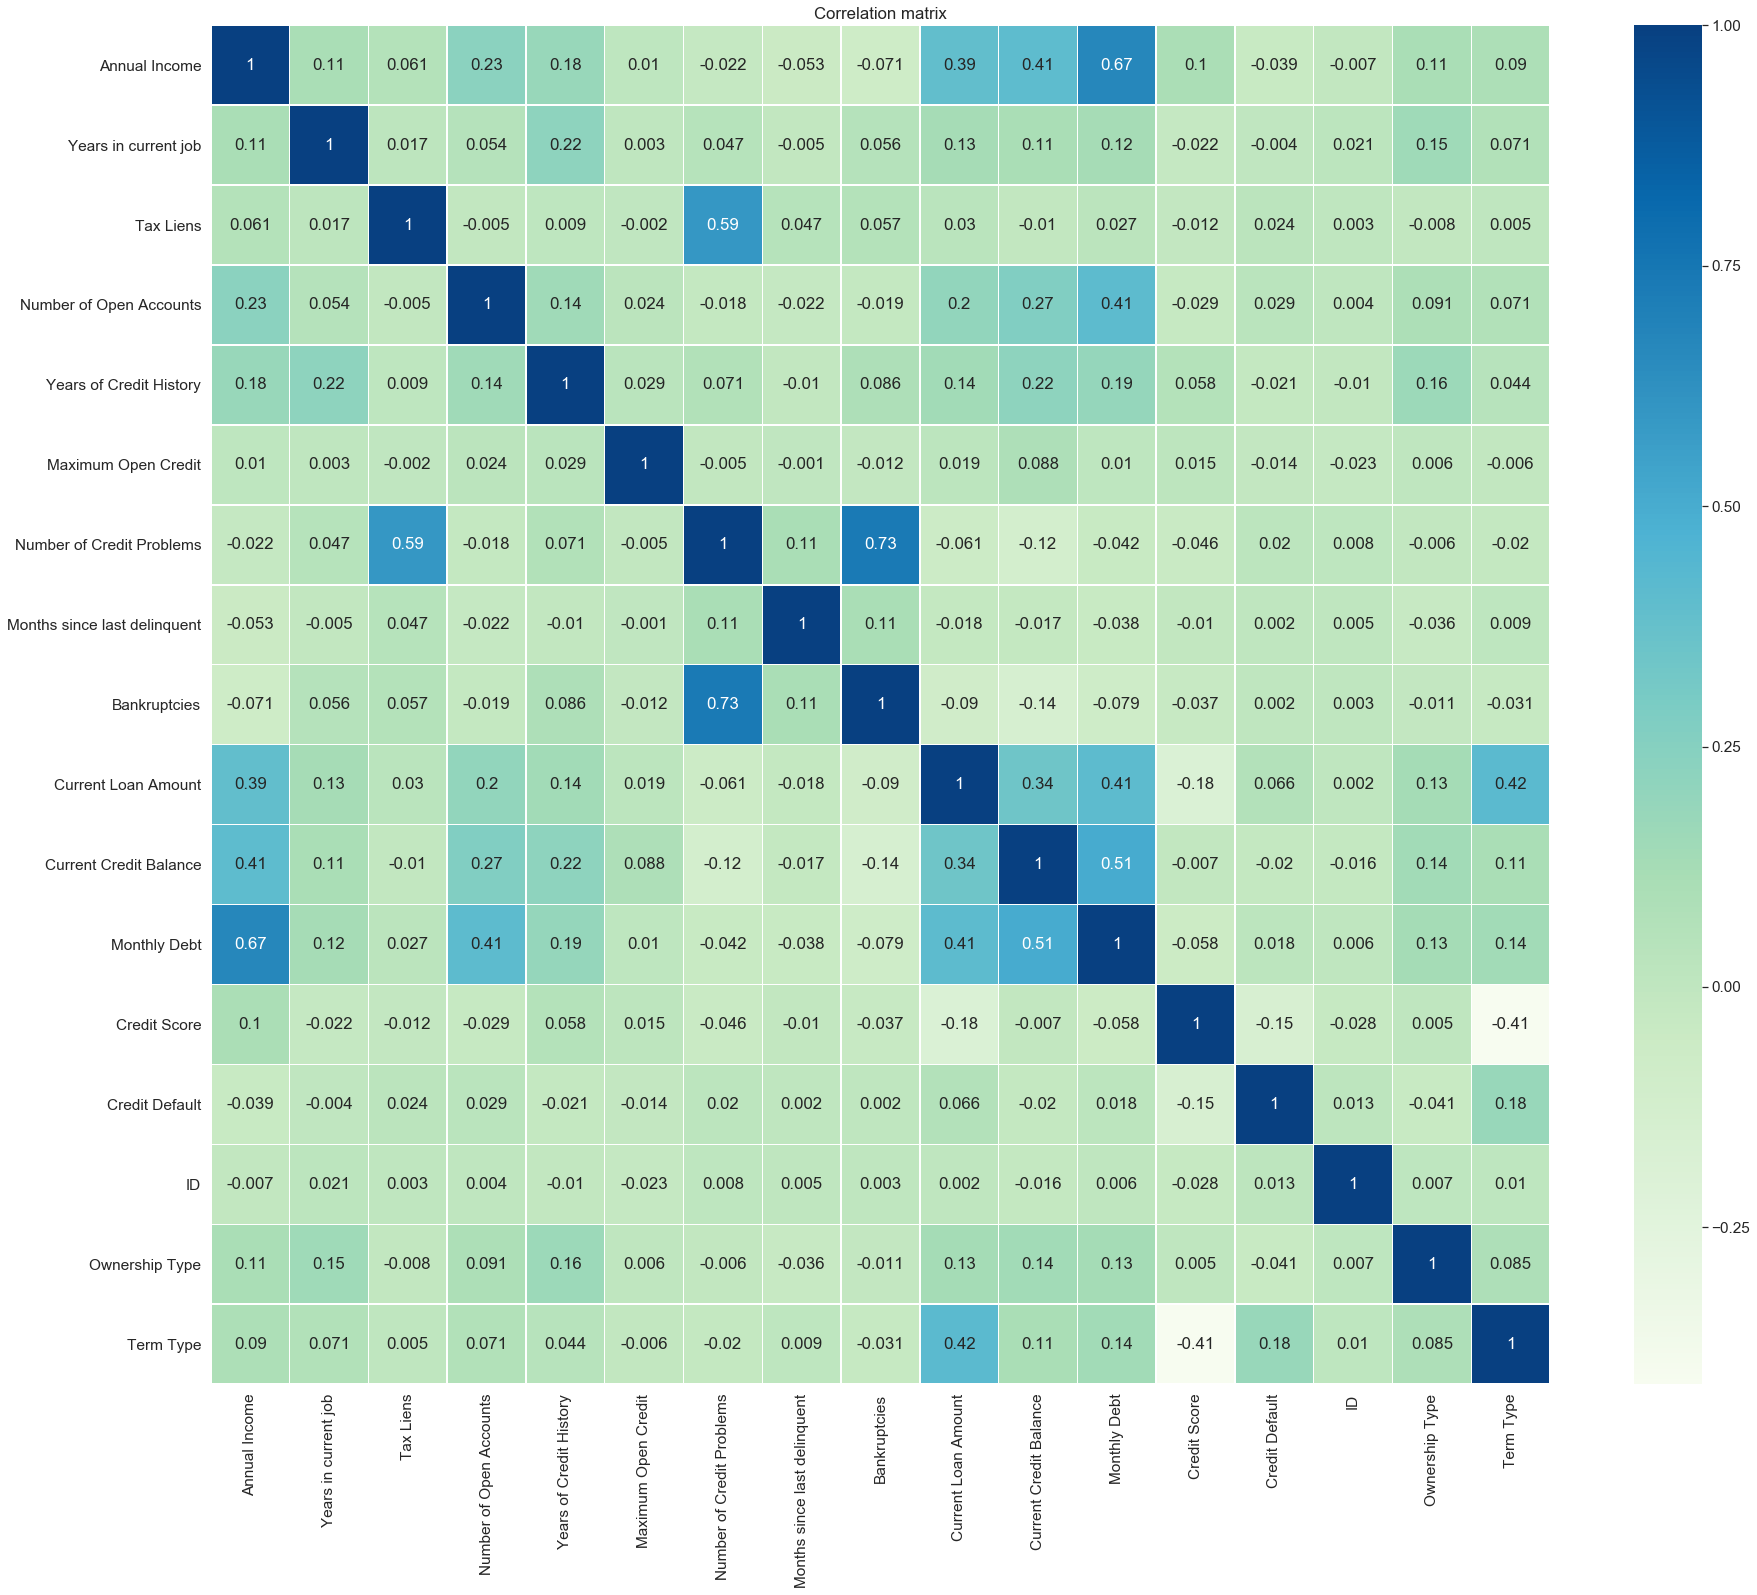

In [92]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### 6. Балансировка классов

In [93]:
TARGET_NAME = 'Credit Default'

# output
TRAIN_FULL_PATH = './course_project_train_full.csv'
TRAIN_PART_PATH = './course_project_train_part_b.csv'
TEST_PART_PATH = './course_project_test_part.csv'

In [94]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [95]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [96]:
SCALER_FILE_PATH = '../scaler.pkl'
MODEL_FILE_PATH = '../model.pkl'

In [97]:
df_base = data_train.copy()

#### 6.1 Выделение целевой переменной и групп признаков

In [98]:
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

In [99]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Ownership Type', 'Term Type']

CAT_FEATURE_NAMES = ['Purpose']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

#### 6.2 Приведение типов для модели CatBoost

In [100]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Purpose    category
dtype: object

#### 6.3 Нормализация данных

In [101]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

#### 6.4 Сохранение модели для нормализации данных

In [102]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

#### 6.5 Разбиение сета на тренировачный и валидационный

In [103]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

#### 6.6 Балансировка целевой переменной

In [104]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

c:\users\dvasilyev\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
c:\users\dvasilyev\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    3771
1    2958
Name: Credit Default, dtype: int64

In [112]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

#### 6.7 Сохранение тренировачного и валидационного сетов

In [113]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [114]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

#### 6.8 Построение и оценка базовых моделей

#### Логистическая регрессия

In [115]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.62      0.80      0.70      3771
           1       0.60      0.38      0.46      2958

    accuracy                           0.61      6729
   macro avg       0.61      0.59      0.58      6729
weighted avg       0.61      0.61      0.60      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1616
           1       0.43      0.38      0.40       634

    accuracy                           0.68      2250
   macro avg       0.60      0.59      0.59      2250
weighted avg       0.67      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1295  321
1                393  241


c:\users\dvasilyev\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### k ближайших соседей

In [116]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3771
           1       0.75      0.67      0.71      2958

    accuracy                           0.76      6729
   macro avg       0.75      0.75      0.75      6729
weighted avg       0.75      0.76      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1616
           1       0.33      0.38      0.35       634

    accuracy                           0.61      2250
   macro avg       0.54      0.54      0.54      2250
weighted avg       0.62      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1132  484
1                396  238


#### Бустинговые алгоритмы

#### LightGBM

In [117]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3771
           1       0.91      0.89      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1616
           1       0.39      0.39      0.39       634

    accuracy                           0.65      2250
   macro avg       0.57      0.57      0.57      2250
weighted avg       0.65      0.65      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1225  391
1                389  245


#### CatBoost

In [118]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoostError: c:/goagent/pipelines/buildmaster/catboost.gittt/catboost/libs/data/features_layout.cpp:94: All feature names should be different, but 'Ownership Type' used more than once.